In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import random
import time
import random

In [ ]:
### Task:
# extract Markov-probabilities from supermarket customer data: with which probability are customers moving from 
# location to location within the supermarket?
# use those probabilites to set up a number of classes that can be used to simulate this supermarket:
# class Customer, class Supermarket

In [ ]:
##############################
### reading-in and resampling
##############################

In [21]:
# read-in multiple files of customer location data and store them in list
df_list = []
df_list.append(pd.read_csv('./data/monday.csv', sep=';', parse_dates=['timestamp']))
df_list.append(pd.read_csv('./data/tuesday.csv', sep=';', parse_dates=['timestamp']))
df_list.append(pd.read_csv('./data/wednesday.csv', sep=';', parse_dates=['timestamp']))
df_list.append(pd.read_csv('./data/thursday.csv', sep=';', parse_dates=['timestamp']))
df_list.append(pd.read_csv('./data/friday.csv', sep=';', parse_dates=['timestamp']))

In [22]:
# take the max customer no of df_i and add it to the customer no of df_i+1
# so that the customer no keeps incrementing over the entire week and not only within a day
for i in range(len(df_list)-1):
    id_max = df_list[i]['customer_no'].max()
    df_list[i+1]['customer_no'] = df_list[i+1]['customer_no'] + id_max

# concat all df in list
df = pd.concat(df_list, axis=0)
# set timestamp as index for resampling
df.set_index('timestamp', inplace=True)
df

,customer_no,location
timestamp,,
2019-09-02 07:03:00,1,dairy
2019-09-02 07:03:00,2,dairy
2019-09-02 07:04:00,3,dairy
2019-09-02 07:04:00,4,dairy
2019-09-02 07:04:00,5,spices
...,...,...
2019-09-06 21:50:00,7435,dairy
2019-09-06 21:50:00,7442,checkout
2019-09-06 21:50:00,7443,checkout


In [23]:
# check for all possible locations
df['location'].unique()

array(['dairy', 'spices', 'fruit', 'checkout', 'drinks'], dtype=object)

In [24]:
# resample df: the original data does not record a datapoint when the customer stays in a location
# we want data that has a timestamp for each minute regardless of staying or changing locations
# (important for Markov probabilites later)

df_resampled = df.groupby('customer_no').resample('1T').ffill()
df.reset_index(inplace=True)

In [25]:
# create time based feature 'hour' from timestamp
df['date_hour'] = df['timestamp'].astype(str).str[:13]

In [ ]:
#############################
# data exploration
############################

In [26]:
# number of customers in sections for the entire timeframe

df.groupby('location').count()['customer_no']

location
checkout    7417
dairy       4679
drinks      3905
fruit       5122
spices      3754
Name: customer_no, dtype: int64

In [40]:
# accumulative number of customers in each section for each hour

df.groupby(['location', 'date_hour']).count()['customer_no']

location  date_hour    
checkout  2019-09-02 07     92
          2019-09-02 08    112
          2019-09-02 09     85
          2019-09-02 10     90
          2019-09-02 11     55
          2019-09-02 12     73
          2019-09-02 13    120
          2019-09-02 14     90
          2019-09-02 15     94
          2019-09-02 16     86
          2019-09-02 17    122
          2019-09-02 18    128
          2019-09-02 19    129
          2019-09-02 20    109
          2019-09-02 21     52
          2019-09-03 07     91
          2019-09-03 08    129
          2019-09-03 09     77
          2019-09-03 10     81
          2019-09-03 11     47
          2019-09-03 12     60
          2019-09-03 13    104
          2019-09-03 14    110
          2019-09-03 15     72
          2019-09-03 16    118
          2019-09-03 17    109
          2019-09-03 18    134
          2019-09-03 19    127
          2019-09-03 20     99
          2019-09-03 21     62
          2019-09-04 07     85
          2019-

In [33]:
# plot: numbers at the checkout for each hour

out = df[df['location'] == 'checkout'].groupby(['date_hour']).count()['customer_no']
fig = px.line(data_frame=out, labels={'date_hour':'Date', 'value':'No. of customers'})
fig.layout.update(showlegend=False)
fig.show()

In [37]:
# time spent by each customer in the shop in minutes

df.groupby('customer_no').count()['timestamp']

customer_no
1       2
2       2
3       2
4       2
5       2
       ..
7441    1
7442    2
7443    2
7444    1
7445    1
Name: timestamp, Length: 7445, dtype: int64

In [38]:
# total number of customers in shop for each hour

df.groupby(['date_hour'])['customer_no'].unique()

date_hour
2019-09-02 07    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
2019-09-02 08    [98, 99, 101, 84, 86, 97, 102, 80, 95, 103, 10...
2019-09-02 09    [167, 192, 203, 206, 208, 212, 215, 216, 199, ...
2019-09-02 10    [288, 293, 294, 300, 301, 302, 303, 279, 286, ...
2019-09-02 11    [361, 380, 382, 384, 385, 371, 386, 387, 388, ...
                                       ...                        
2019-09-06 17    [6883, 6885, 6886, 6891, 6892, 6893, 6882, 689...
2019-09-06 18    [6978, 6990, 6999, 7000, 7004, 7006, 7007, 701...
2019-09-06 19    [7142, 7149, 7152, 7154, 7162, 7141, 7156, 715...
2019-09-06 20    [7277, 7279, 7293, 7297, 7298, 7299, 7300, 730...
2019-09-06 21    [7370, 7387, 7389, 7391, 7393, 7394, 7383, 739...
Name: customer_no, Length: 75, dtype: object

<AxesSubplot:xlabel='location'>

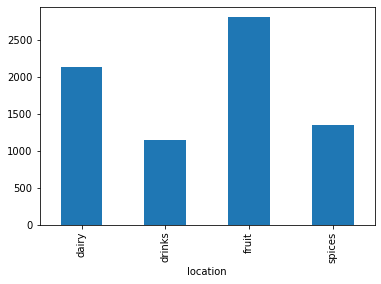

In [39]:
# first section visited

df.groupby(['customer_no']).first().groupby('location').count()['timestamp'].plot.bar()

<AxesSubplot:xlabel='location'>

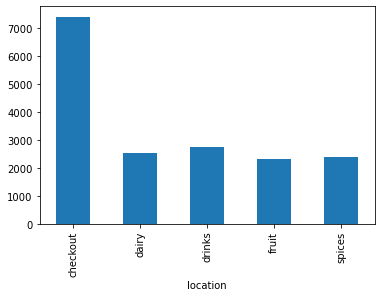

In [40]:
# following section visited

df.sort_values(['customer_no', 'timestamp']).groupby('customer_no').nth[1:].groupby('location').count()['timestamp'].plot.bar()


In [42]:
# revenue per minute (given in course material)

df_rev = pd.DataFrame({'location': ['fruit', 'spices', 'dairy', 'drinks'], 'revenue per minute': [4, 3, 5, 6]})
df_rev

,location,revenue per minute
0,fruit,4
1,spices,3
2,dairy,5
3,drinks,6


In [43]:
# merge respective revenue to each entry in df

df = df.merge(right=df_rev, how='left', on='location')

In [44]:
# find the most profitable section

df.groupby('location')['revenue per minute'].sum()

location
checkout        0.0
dairy       23395.0
drinks      23430.0
fruit       20488.0
spices      11262.0
Name: revenue per minute, dtype: float64

In [46]:
# backward-fill the last location (transform 'last') and count rows that have not checked out of the supermarket

df['last_loc'] = df.groupby('customer_no')['location'].transform('last')
df.groupby('last_loc').count()

,timestamp,customer_no,location,date_hour,revenue per minute
last_loc,,,,,
checkout,24798,24798,24798,24798,17381
dairy,37,37,37,37,37
drinks,3,3,3,3,3
fruit,22,22,22,22,22
spices,17,17,17,17,17


In [47]:
# only a very small percentage has not checked out. for simplicity we just throw them out:
# select only customers who have checked out for cleaner probabilities

df = df.loc[df['last_loc'] == 'checkout']

In [48]:
##############################################
### Calculate Markov transition probabilities
##############################################

before = df.sort_values(['customer_no', 'timestamp'])['location']
# create time shifted data
after = before.shift(-1)
# merge them back together
data = pd.concat([before, after], axis=1, keys=['before', 'after'])
# throw out the lines after check outs (where customer id increments)
data = data[data['before'] != 'checkout']
# calculate Markov probabilites with .crosstab function
prob = pd.crosstab(data['before'], data['after'], normalize=0)

In [49]:
# manually insert row for checkout (no turning back)
check_row = pd.DataFrame(data=[['checkout',0,0,0,0,0]], columns=prob.reset_index().columns)
prob = pd.concat([check_row, prob.reset_index()], axis=0)
prob.set_index('before', inplace=True)

In [64]:
# save probabilities to csv for other script
prob.to_csv('./data/prob.csv')

In [50]:
# calculate probability for first section (start of markov chain/entry into supermarket)
#df = df.reset_index()
prob_first = df.groupby(['customer_no']).first().groupby('location').count()['timestamp'] / df.groupby(['customer_no']).first().groupby('location').count()['timestamp'].sum()
prob_first.to_csv('./data/prob_first.csv')

In [55]:
### Test Markov Chain with single customer

chain = []

# determine section of entry
section = random.choices(population=prob_first.index, weights=prob_first.values)

while True:
    chain.append(section[0])
    if section[0] == 'checkout':
        break
    # determine next section
    section = random.choices(population=prob.columns, weights=prob.loc[section].values[0])
# output chain of locations
chain    

['fruit', 'dairy', 'fruit', 'checkout']

In [58]:
############################################### 
### Object oriented approach
###############################################

class Customer():
    def __init__(self, customer_no):
        self.section = random.choices(population=prob_first.index, weights=prob_first.values)
        self.sections = self.section
        self.in_shop = True
        self.customer_no = customer_no
        
    def __repr__(self):
        if self.in_shop:
            return f"Customer {self.customer_no} is in section '{self.section[0]}'."
        else:
            return f"Customer {self.customer_no} has left the shop"
        
    def compute(self):
        if self.in_shop:
            self.old_section = self.section[0]
            self.section = random.choices(population=prob.columns, weights=prob.loc[self.section].values[0])
            self.sections.append(self.section[0]) 
            if self.section[0] == 'checkout':
                    self.in_shop = False
            return f"Customer {self.customer_no} moved from '{self.old_section}' to '{self.section[0]}'."
        else:
            return f"Customer {self.customer_no} has left the shop from '{self.old_section}'."

In [59]:
# supermarket class

class Supermarket():
    def __init__(self):
        self.customers = []
        self.n_customers = len(self.customers)
        self.running_id = 0
        
    def __repr__(self):
        return f"Supermarket with {self.n_customers} customers."
    
    def add_customers(self, n=1):
        for i in range(self.running_id, self.running_id + n):
            self.customers.append(Customer(i))
        self.n_customers = len(self.customers)
        self.running_id += n
            
    def compute_market(self):
        state = []
        have_left = []
        for customer in self.customers:
            print(customer.compute())
            state.append([customer.customer_no, customer.section[0]])
            if not customer.in_shop:
                have_left.append(customer)
        self.customers = [x for x in self.customers if x not in have_left]
        #self.customers = list(set(self.customers) - set(have_left))
        self.n_customers = len(self.customers)
        return state

In [74]:
### Setting up simulation of supermarket with classes from above

# define time range for simulation
timestamps = pd.date_range(start='2022-12-22 07:00:00', end='2022-12-22 09:00:00', freq='1T')
# instanciate supermarket
s = Supermarket()

output = []

# run loop
for timestamp in timestamps:
    # add random number of customers each time step
    s.add_customers(random.randint(0,3))
    # run supermarket for one timestep
    result = s.compute_market()
    # save results
    output.append(pd.DataFrame([[timestamp,row[0],row[1]] for row in result], columns= ['timestamp','customer_id','location']))
    

Customer 0 moved from 'fruit' to 'checkout'.
Customer 1 moved from 'dairy' to 'checkout'.
Customer 2 moved from 'dairy' to 'spices'.
Customer 2 moved from 'spices' to 'checkout'.
Customer 3 moved from 'dairy' to 'spices'.
Customer 4 moved from 'fruit' to 'checkout'.
Customer 5 moved from 'fruit' to 'dairy'.
Customer 3 moved from 'spices' to 'checkout'.
Customer 5 moved from 'dairy' to 'spices'.
Customer 6 moved from 'fruit' to 'spices'.
Customer 7 moved from 'fruit' to 'drinks'.
Customer 5 moved from 'spices' to 'drinks'.
Customer 6 moved from 'spices' to 'checkout'.
Customer 7 moved from 'drinks' to 'spices'.
Customer 5 moved from 'drinks' to 'checkout'.
Customer 7 moved from 'spices' to 'dairy'.
Customer 7 moved from 'dairy' to 'fruit'.
Customer 8 moved from 'spices' to 'dairy'.
Customer 7 moved from 'fruit' to 'checkout'.
Customer 8 moved from 'dairy' to 'checkout'.
Customer 9 moved from 'dairy' to 'spices'.
Customer 9 moved from 'spices' to 'drinks'.
Customer 10 moved from 'dairy' 

Customer 99 moved from 'spices' to 'drinks'.
Customer 101 moved from 'spices' to 'drinks'.
Customer 102 moved from 'spices' to 'checkout'.
Customer 98 moved from 'fruit' to 'checkout'.
Customer 99 moved from 'drinks' to 'spices'.
Customer 101 moved from 'drinks' to 'fruit'.
Customer 103 moved from 'spices' to 'drinks'.
Customer 104 moved from 'fruit' to 'dairy'.
Customer 99 moved from 'spices' to 'fruit'.
Customer 101 moved from 'fruit' to 'checkout'.
Customer 103 moved from 'drinks' to 'dairy'.
Customer 104 moved from 'dairy' to 'drinks'.
Customer 99 moved from 'fruit' to 'dairy'.
Customer 103 moved from 'dairy' to 'checkout'.
Customer 104 moved from 'drinks' to 'dairy'.
Customer 105 moved from 'dairy' to 'drinks'.
Customer 99 moved from 'dairy' to 'spices'.
Customer 104 moved from 'dairy' to 'checkout'.
Customer 105 moved from 'drinks' to 'spices'.
Customer 106 moved from 'spices' to 'drinks'.
Customer 107 moved from 'fruit' to 'checkout'.
Customer 99 moved from 'spices' to 'dairy'.


Customer 182 moved from 'dairy' to 'checkout'.
Customer 183 moved from 'drinks' to 'checkout'.
Customer 184 moved from 'fruit' to 'checkout'.
Customer 185 moved from 'dairy' to 'spices'.
Customer 186 moved from 'dairy' to 'fruit'.
Customer 187 moved from 'drinks' to 'fruit'.
Customer 185 moved from 'spices' to 'checkout'.
Customer 186 moved from 'fruit' to 'checkout'.
Customer 187 moved from 'fruit' to 'checkout'.
Customer 188 moved from 'fruit' to 'drinks'.
Customer 189 moved from 'drinks' to 'checkout'.
Customer 188 moved from 'drinks' to 'checkout'.
Customer 190 moved from 'dairy' to 'drinks'.
Customer 191 moved from 'dairy' to 'fruit'.
Customer 190 moved from 'drinks' to 'checkout'.
Customer 191 moved from 'fruit' to 'drinks'.
Customer 192 moved from 'drinks' to 'checkout'.
Customer 191 moved from 'drinks' to 'checkout'.
Customer 193 moved from 'dairy' to 'fruit'.
Customer 194 moved from 'fruit' to 'drinks'.
Customer 195 moved from 'spices' to 'drinks'.


In [61]:
# create df that contains all simulation data

sim = pd.concat(output)
sim['date_str'] = sim['timestamp'].astype(str)
sim

,timestamp,customer_id,location,date_str
0,2022-12-22 07:00:00,0,spices,2022-12-22 07:00:00
1,2022-12-22 07:00:00,1,fruit,2022-12-22 07:00:00
2,2022-12-22 07:00:00,2,spices,2022-12-22 07:00:00
0,2022-12-22 07:01:00,0,checkout,2022-12-22 07:01:00
1,2022-12-22 07:01:00,1,checkout,2022-12-22 07:01:00
...,...,...,...,...
3,2022-12-22 08:59:00,183,spices,2022-12-22 08:59:00
4,2022-12-22 08:59:00,184,checkout,2022-12-22 08:59:00
0,2022-12-22 09:00:00,180,checkout,2022-12-22 09:00:00
1,2022-12-22 09:00:00,181,checkout,2022-12-22 09:00:00


In [56]:
######################################
### Visualization
######################################

# in other Notebook